# Decsion Tree Analysis
Model Training and Feature Selection

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

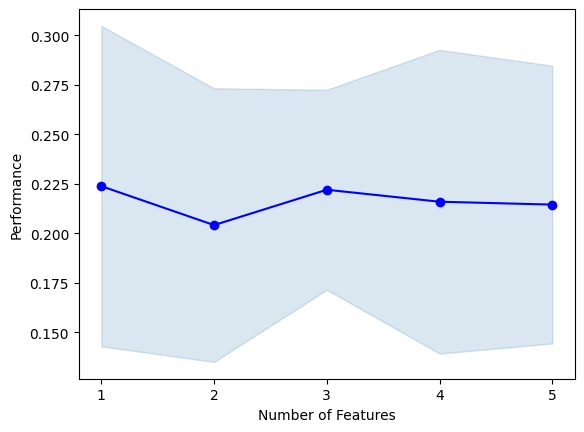

In [15]:
from data_cleaning import ratings_df, watchlist_df, valid_int
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree
from mlxtend.feature_selection import SequentialFeatureSelector as SFS 
from mlxtend.plotting import plot_sequential_feature_selection



#? Model training & Feature selection : Wrapper - Sequential Forward Floating Selector (SFFS)
model = DecisionTreeRegressor(max_depth = 5, random_state=42)

X = ratings_df[["IMDb Rating", "Runtime (mins)", "Year", "Num Votes", "Day_Rated"]] 
y = ratings_df['Your Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sffs = SFS(model,
          k_features=5, # k=4 for best performance, however setting to 1 so visualsie performance on graph for k 1 through to 5
          forward=True,
          floating=True,
          scoring='r2',
          cv=5)

sffs.fit(X_train, y_train)

selected_features = X_train.columns[list(sffs.k_feature_idx_)] # ['IMDb Rating', 'Year', 'Day_Rated']

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model = DecisionTreeRegressor(max_depth=5, random_state=42)

#? Model 1 & 2
model.fit(X_train, y_train)
# model.fit(X_train_selected, y_train) # --- With Feature selection

#? Feature selection evaluation
# print(sffs.subsets_)
plot_sequential_feature_selection(sffs.get_metric_dict(), kind='std_dev')  


## Model Evaluation

In [16]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Model 1)  \nMean Absolute Error: {round(mae, 3)}')
train_score = model.score(X_train, y_train)
print(f'Training R-squared: {round(train_score, 3)}')
test_score = model.score(X_test, y_test)
print(f'Test R-squared: {round(test_score, 3)}', '\n')

print('Model 2) With feature selection \nMean Absolute Error: 0.934 ') # (K=3) These values were worked out by using model 2 and replacing X test and train scaled with X test and train selected!
print('Test R-squared: 0.389')
print('Training R-squared: 0.235')

# print(model.coef_)
# print(model.intercept_) 

Model 1)  
Mean Absolute Error: 0.959
Training R-squared: 0.445
Test R-squared: 0.228 

Model 2) With feature selection 
Mean Absolute Error: 0.934 
Test R-squared: 0.389
Training R-squared: 0.235


## Visualising model Performance for different max depths

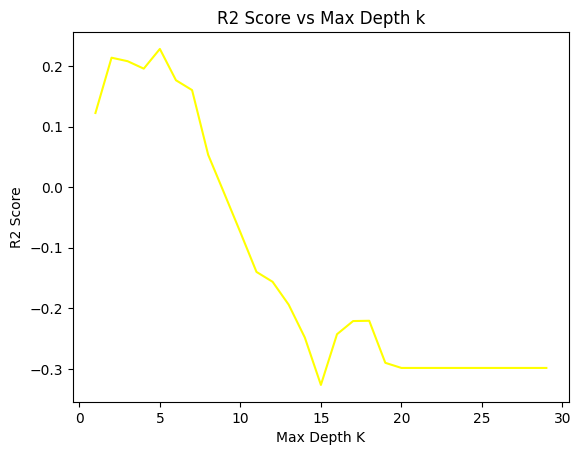

Best k value: 5
Best r2_score: 0.2282


In [17]:
def best_max_depth(training_data, training_labels, test_data, test_labels):
    r2_scores = []

    for k in range(1, 30):
        model = DecisionTreeRegressor(max_depth = k, random_state=42)
        model.fit(training_data, training_labels)
        r2_score = model.score(test_data, test_labels)
        r2_scores.append(r2_score)

    
    best_k_value = np.argmax(r2_scores) + 1  
    best_r2_score = r2_scores[best_k_value - 1]  

    return best_k_value, best_r2_score, r2_scores


k_list = range(1, 30) # r2_score plateus at max_depth = 18 onwards!
best_k_value, best_r2_score, r2_scores2 = best_max_depth(X_train, y_train, X_test, y_test) 


plt.plot(k_list, r2_scores2, color="yellow")
plt.xlabel('Max Depth K')
plt.ylabel('R2 Score')
plt.title('R2 Score vs Max Depth k')
plt.show()

print(f"Best k value: {best_k_value}")
print(f"Best r2_score: {round(best_r2_score, 4)}") 

## Visualisation of Decision Tree at max_depth = 5

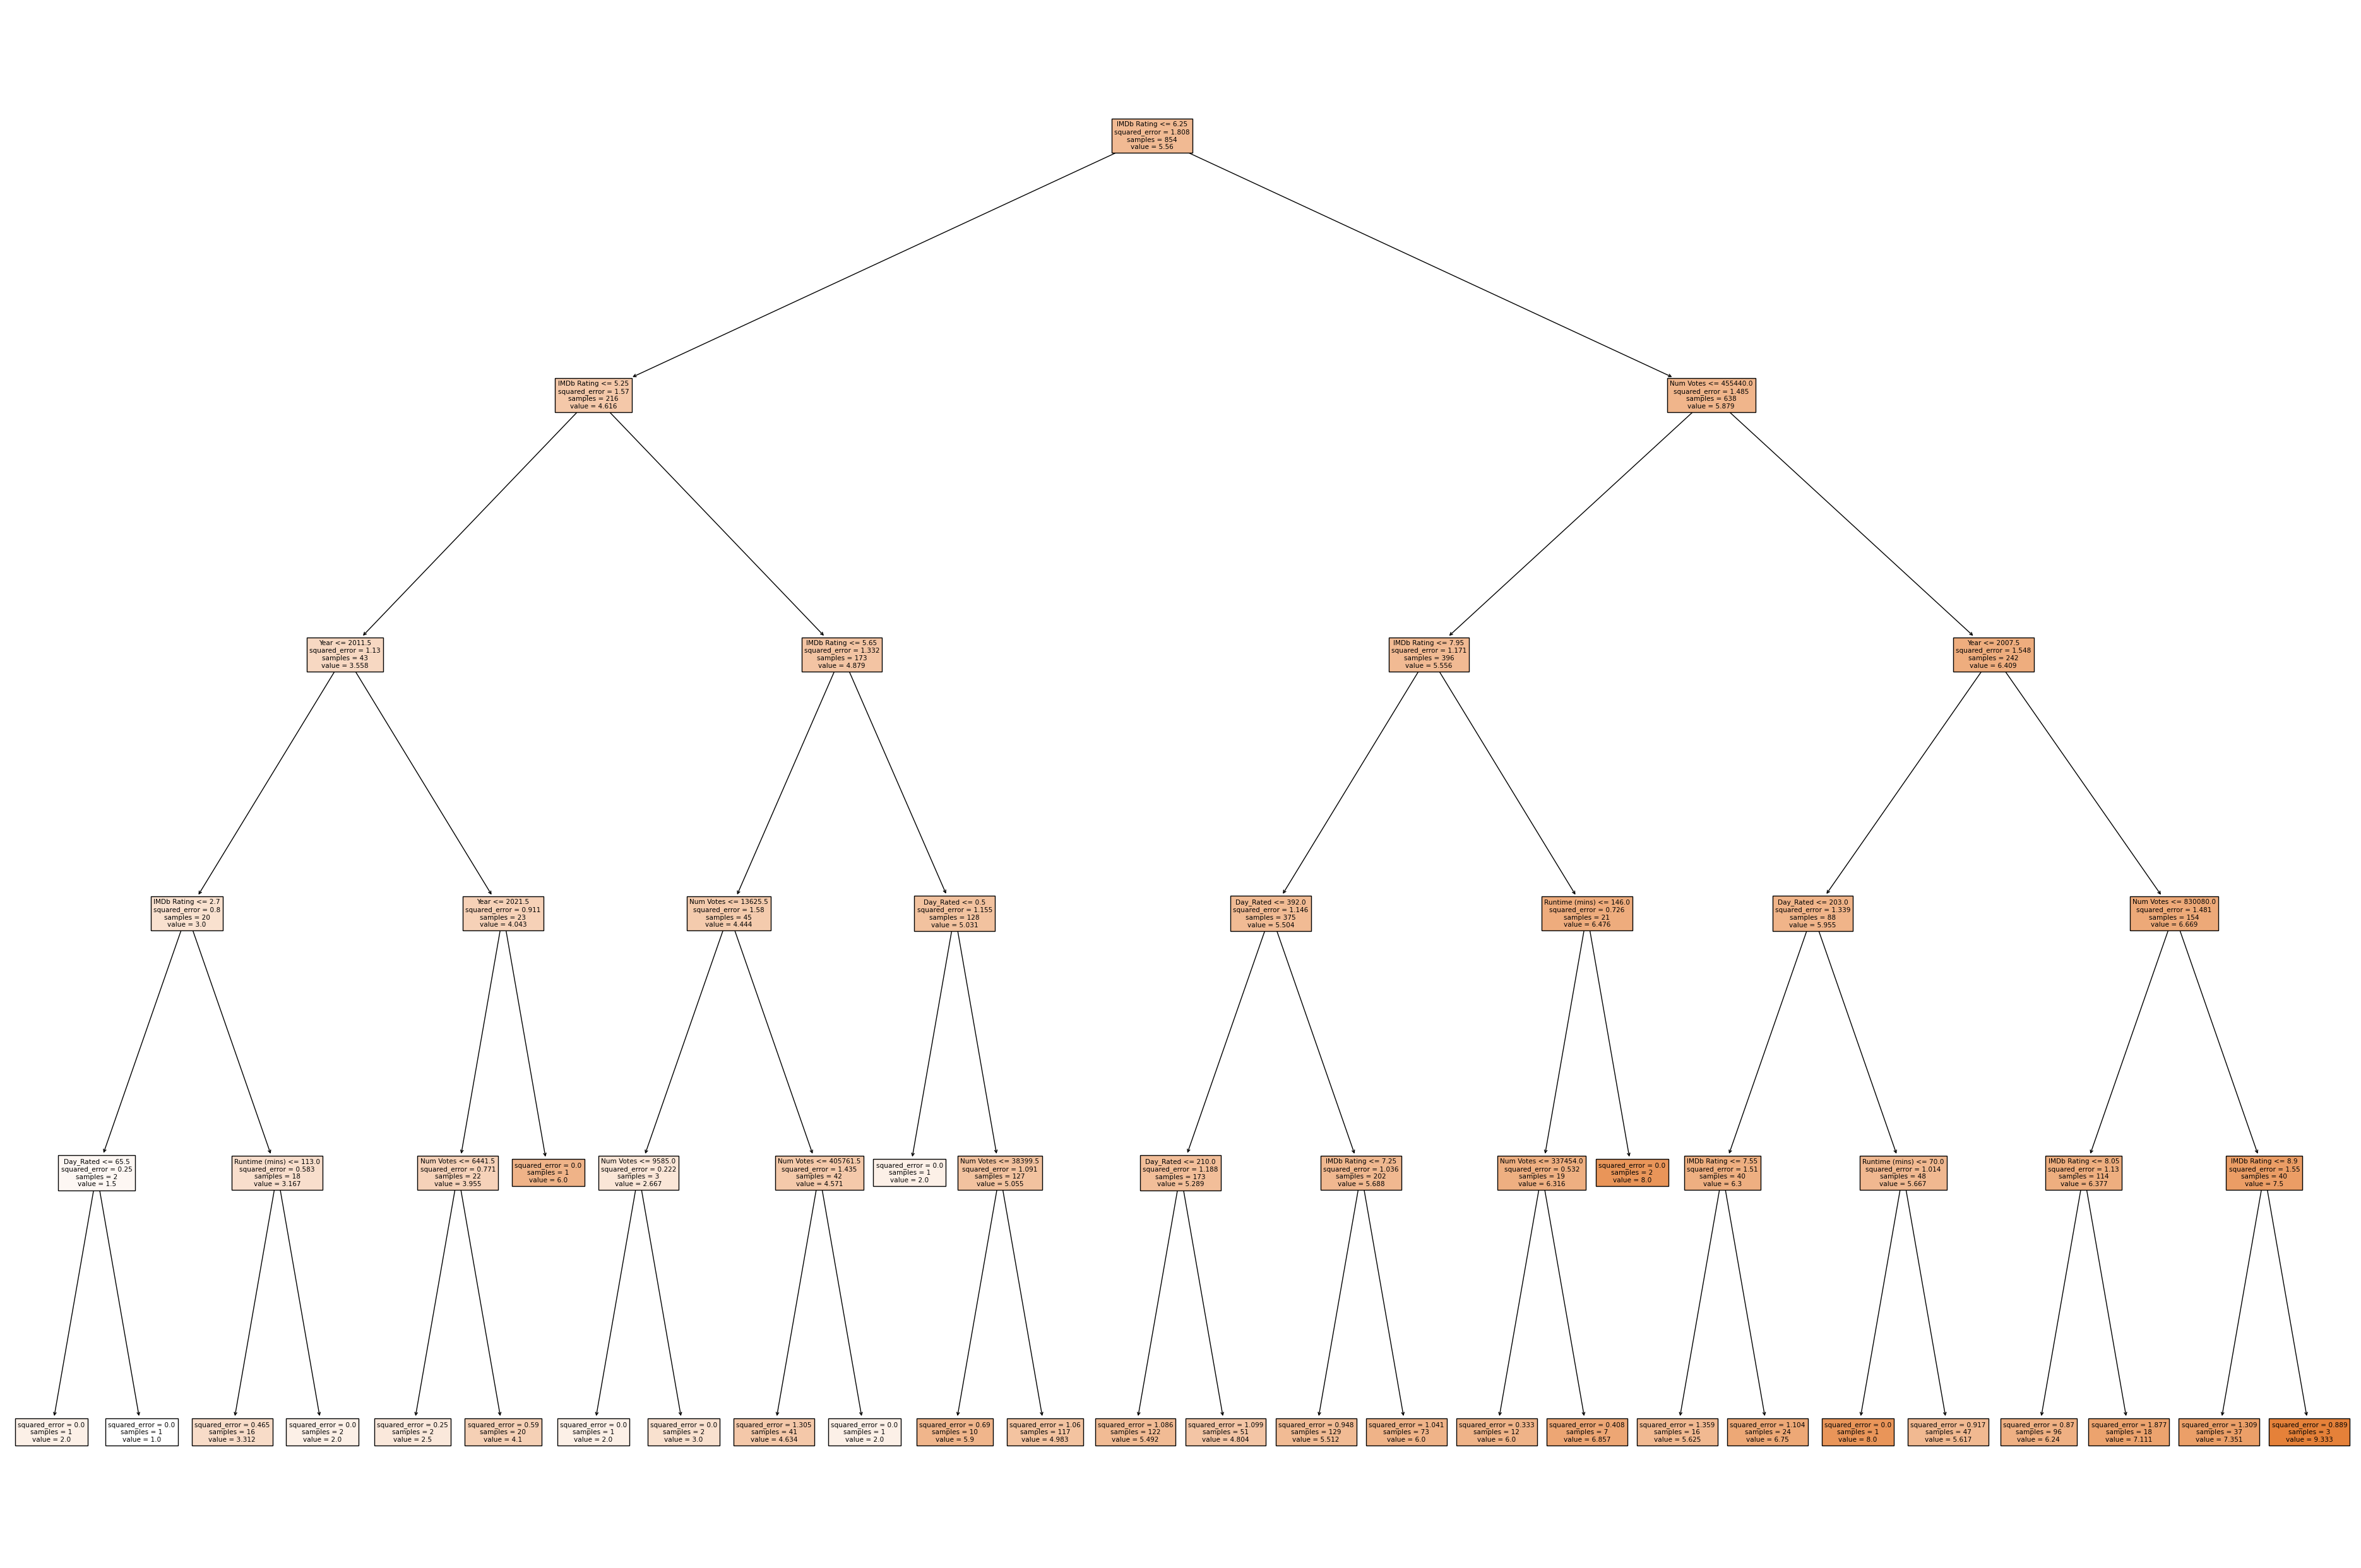

In [18]:
plt.figure(figsize=(48, 32)) #* Make this bigger than it becomes more readable!
plot_tree(model, filled=True, feature_names=X.columns)
plt.show()

# print(tree.export_text(model))

## Predictions on Watchlist

In [19]:
#! Making sure the predictions df lines up with ratings_df
watchlist_df2 = watchlist_df.drop("Title", axis=1).copy()
watchlist_df2 = watchlist_df2[["IMDb Rating", "Runtime (mins)", "Year", "Num Votes", "Day_Rated"]]

# Predictions
predictions = np.round(model.predict(watchlist_df2), 1) # Rounded to make it a closer resemblence to acutal IMDb Ratings..

pred_titles = list(zip(watchlist_df['Title'], predictions))
sorted_predictions = sorted(pred_titles, key=lambda x: x[1], reverse=True)

for title, rating in sorted_predictions:
    print(f'{title}: {rating}')

Whiplash: 7.4
La La Land: 6.2
Rogue One: 6.2
Everything Everywhere All at Once: 6.2
Match Point: 6.0
The Machinist: 6.0
The Edge of Seventeen: 6.0
The Game: 6.0
The Life of David Gale: 6.0
Euphoria: 6.0
The Town: 6.0
The Departed: 5.6
American Reunion: 5.5
Under the Skin: 5.5
Ride Like a Girl: 5.5
Midsommar: 5.5
Magnus: 5.5
The Man Who Knew Infinity: 5.5
Don't Worry Darling: 5.5
Triple Frontier: 5.5
Pawn Sacrifice: 5.5
Absolutely Anything: 5.0
Don't Breathe 2: 5.0
Something Borrowed: 5.0
The Place of No Words: 2.0


## User Input Predictions

In [20]:
# Some movies that you can try:
# The Godfather, 9.2, 175, 1972, 2000000
# Napoleon, 6.5, 158, 2023, 95000
# Frozen 2, 6.8, 103, 2019, 191000

def user_predict():
    movie_title = input("Enter the name of the movie/ tv show you would like rated: ")
    imdb_rating = valid_int("Enter the IMDb rating: ", 0, 10)
    runtime = valid_int("Enter the runtime in minutes: ", 0, 250)
    year = valid_int("Enter the year of release: ", 1888, 2024)
    num_votes = valid_int("Enter the number of votes on Imdb: ", 0, 2134288)

    new_data = pd.DataFrame({
        'IMDb Rating': [imdb_rating],
        'Runtime (mins)': [runtime],
        'Year': [year],
        'Num Votes': [num_votes],
        'Day_Rated': [3487] # defaulted as present day : 26/1/24
    })

    predicted_rating = np.round(model.predict(new_data),1)
    print(f'\nPredicted rating for {movie_title}: {predicted_rating[0]}')

#! user_predict() # --------- UNCOMMENT this line to use the predicter function

## Visulisation of Predicted vs Actual Rating

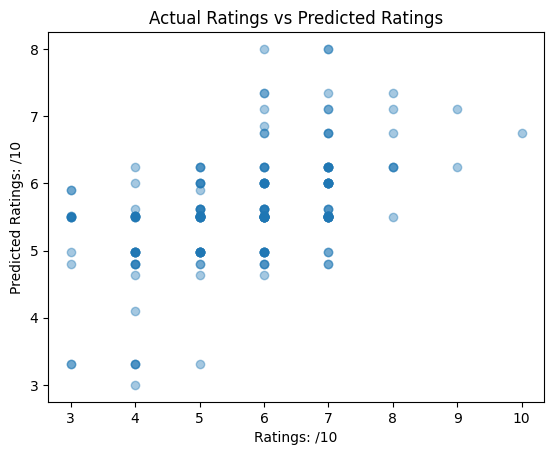

In [21]:
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Ratings: /10")
plt.ylabel("Predicted Ratings: /10")
plt.title("Actual Ratings vs Predicted Ratings")
plt.show() 